In [1]:
import wotan
from wotan import flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import yscale
import lightkurve as lk
from altaipony.flarelc import FlareLightCurve
from lightkurve.lightcurvefile import TessLightCurveFile
from lightkurve.lightcurve import TessLightCurve
from altaipony.ffd import FFD
from astropy.timeseries import LombScargle

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
%matplotlib inline

In [10]:
def detrend_biweight(lc):
    flatten_lc, trend_lc = flatten(
    lc.time.value,             
    lc.flux.value,                
    method='biweight',
    window_length=.1,    
    break_tolerance=0.5,  
    return_trend=True,   
    )
    detrended_lc = FlareLightCurve(lc.time.value, lc.flux.value)
    detrended_lc['detrended_flux']= trend_lc
    detrended_lc['detrended_flux_err']  = lc.flux_err
    return detrended_lc

In [11]:
def make_plot(tic_id, data_dir): 
    
    window_size = .01
    lc_df = pd.read_csv(data_dir+'/TIC '+tic_id+'.CSV')
    ls_df = lc_df[['time', 'flux', 'flux_err']]

    ls_df = ls_df.dropna()

    raw_times = np.array(ls_df['time'])
    raw_fluxes = np.array(ls_df['flux'])
    raw_flux_errs = np.array(ls_df['flux_err'])
    
    light_curve = lk.LightCurve(time=raw_times, flux=raw_fluxes, flux_err=raw_flux_errs)
    light_curve = light_curve.remove_outliers(sigma=3).normalize()

    times = np.array(light_curve.time.value)
    fluxes = np.array(light_curve.flux.value)
    flux_errs = np.array(light_curve.flux_err)
    
    # FIX to use detrended / clipped lc

    ### MAKE PLOT
    plt.style.use('C:/Users/60002/Documents/GitHub/sunnyhills/other/aesthetics/science.mplstyle') # set style...should work on all our computers because relative

    # try with "root path" set to "./other/aesthetics/science.mplstyle"

    mosaic = """
        AAB
        CCD
        EEF
        """

    fig = plt.figure(constrained_layout=True, figsize=(12,6))
    ax_dict = fig.subplot_mosaic(mosaic)

    # A is raw light curve
    ax_dict['A'].scatter(raw_times, raw_fluxes, s=3)
    ax_dict['A'].set(xlabel='Time (d)', ylabel='Raw Normalized Flux')

    # to axis one of the subplots, do it like this: ax_dict['A'] (e.g. for subplot A)

    # lomb-periodogram 
    # max frequency = observation window / 3
    # min frequency = ???

    # ls won't work when nans in array 
    
    window_length = np.max(times)-np.min(times)
    periodogram = LombScargle(times, fluxes, flux_errs)

    false_alarm_levels = [0.01]
    faps = periodogram.false_alarm_level(false_alarm_levels)

    frequencies, powers = periodogram.autopower(minimum_frequency=3/window_length, maximum_frequency=10)
    # max freq and min freq 
    periods = 1/frequencies 

    
    lc = FlareLightCurve(raw_times,raw_fluxes,raw_flux_errs,mission='TESS')

    detrended = lc.detrend("custom",func=detrend_biweight)
    detrended = detrended.find_flares()
    simple_ffd= FFD(f=detrended.flares)
    

    simple_ffd.tot_obs_time = 20
    ed, freq,count= simple_ffd.ed_and_freq()

    ax_dict['B'].scatter(ed, freq)
    ax_dict['B'].set(xscale="log",yscale="log")
    ax_dict['B'].set(xLabel="ED [s]",yLabel="cumulative num of flares")

    try:
        simple_ffd.fit_powerlaw("mmle")
        simple_ffd.plot_powerlaw(ax_dict['B'], c="r", label=fr'$/alpha=$-{simple_ffd.alpha:.1f}')
    except ValueError:
        print("error")
    except ZeroDivisionError:
        print("error")

    try:
        for start,stop in zip(detrended.flares['tstart'],detrended.flares['tstop']):
            ax_dict['C'].axvline(x=start,c="green", label='Flare Start')
            ax_dict['C'].axvline(x=stop,c="red",label='Flare Stop')
    except IndexError:
        print('no flares!')
    ax_dict['C'].plot(times,fluxes)
    
        
    # add FAP and harmonic notatio

    
 
    fap_99 = faps[0]
    more_than_fap_mask = np.where(powers>fap_99)
    periods = periods[more_than_fap_mask]
    powers = powers[more_than_fap_mask]
    sorted_indices = np.argsort(powers)[::-1]
    sorted_powers = powers[sorted_indices][0:20]
    sorted_periods = periods[sorted_indices][0:20]
    if len(sorted_periods)>0: 
        best_period = sorted_periods[0] # get period corresponding to highest power
        best_period_power = sorted_powers[0]
    else: 
        best_period = 0
        best_period_power = 0
    has_harmonic = False 
    if best_period != 0: 
        for i in range(2,6): 
            lower = best_period/i
            upper = best_period*i
                
    ax_dict['D'].scatter(raw_times, raw_fluxes, s=1,label='Biweight Detrend')
    ax_dict['D'].plot(raw_times, detrended.detrended_flux, color='red', linewidth=1)
    
                
    # sigma clipped light curve 
    ax_dict['E'].scatter(raw_times, detrended.detrended_flux, s=1)
    ax_dict['E'].set(xlabel='Time (d)', ylabel='detrended light curve')
    e_xlabel = 'Phase (P='+str(round(best_period,2))+' d)'
    if best_period != 0: 
        phased_dates = np.mod(times, best_period)/best_period # phase the dates
        ax_dict['F'].scatter(phased_dates, fluxes, s=3)
        
    else: 
        e_xlabel = 'Phase (P= nan d)'
    ax_dict['F'].set(xlabel=e_xlabel, ylabel='Normalized Flux (FIX)')

    # metadata to save after each iteration: 
    '''

    Note: end results for the entire iteration should be one .csv with id column and columns for the parameters below, which are populated by row/ID basis  

    LombScargle Related: 
    > top_period
    > top_period_power
    > fap_99 
    > top period is harmonic (True/False) # fix because is vs possesses is different 
    
    Flare Related: 
    > add number of flares

    '''


    plt.show()
    fig.savefig('C:/Users/60002/Documents/GitHub/sunnyhills/data/current/plots/fixed_detrend/'+tic_id,transparent=False,facecolor="white")
    ## LC MOSAIC KEY FOR NOW 
    """
    A: raw light curve 
    B: flare frequency plot
    C: raw light curve with annotated flares
    D: Detrended Light Curve
    E: iterative 3 sigma clipped light curve
    F: Phase folded light curve 
    """


C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,7150) gap.
Found 0 candidate(s) in the (7150,14209) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


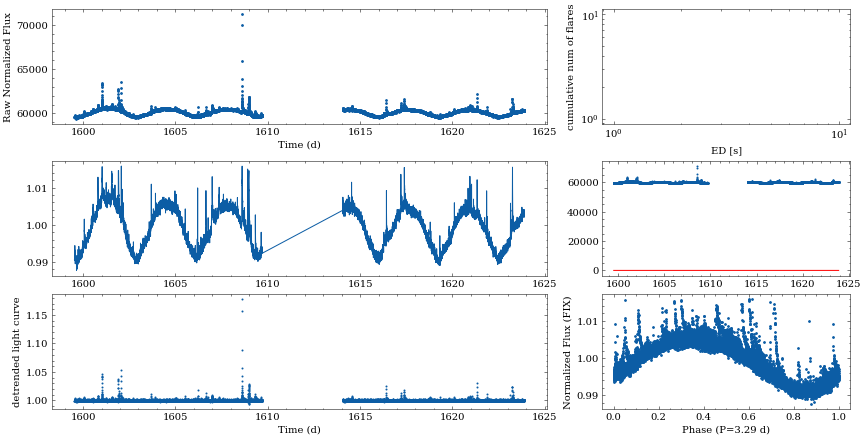

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,9409) gap.
Found 0 candidate(s) in the (9409,18277) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


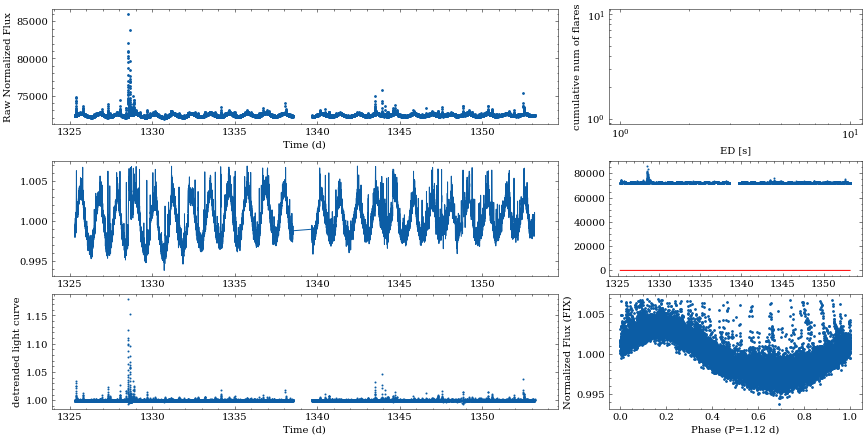

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8168) gap.
Found 0 candidate(s) in the (8168,16334) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


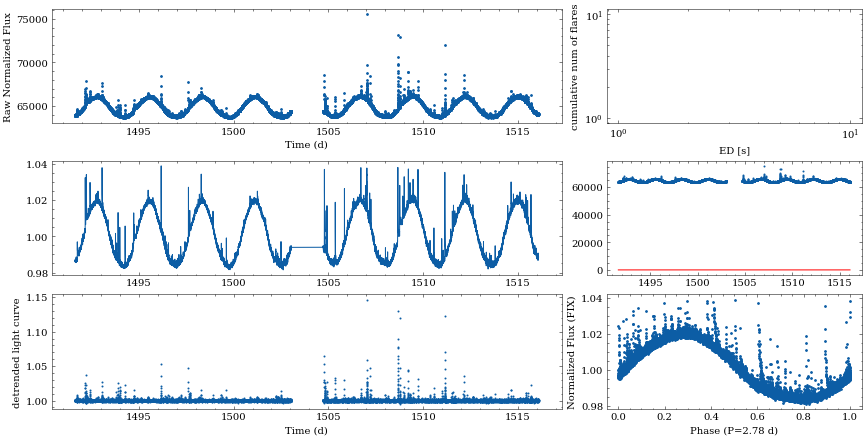

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8056) gap.
Found 0 candidate(s) in the (8056,15869) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


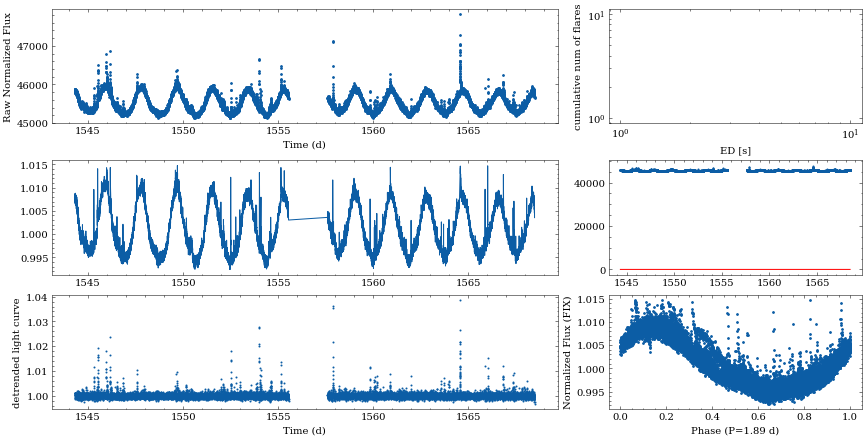

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8537) gap.
Found 0 candidate(s) in the (8537,17241) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


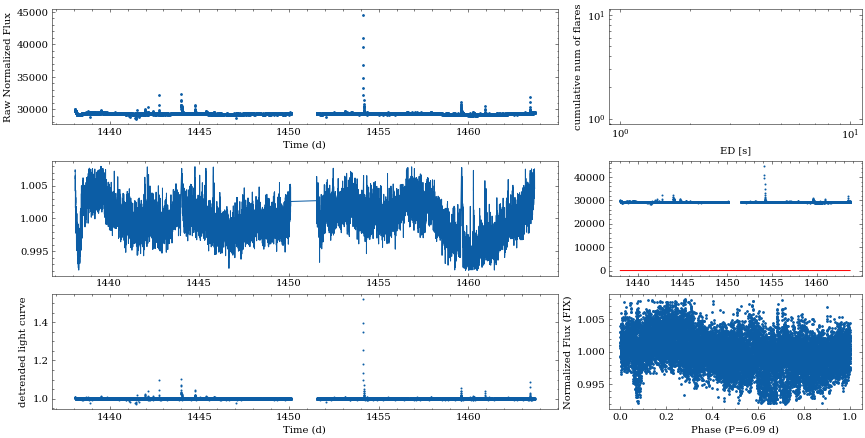

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,85) gap.
Found 0 candidate(s) in the (85,210) gap.
Found 0 candidate(s) in the (210,401) gap.
Found 0 candidate(s) in the (401,463) gap.
Found 0 candidate(s) in the (463,514) gap.
Found 0 candidate(s) in the (514,573) gap.
Found 0 candidate(s) in the (573,696) gap.
Found 0 candidate(s) in the (696,759) gap.
Found 0 candidate(s) in the (759,820) gap.
Found 0 candidate(s) in the (820,939) gap.
Found 0 candidate(s) in the (939,1001) gap.
Found 0 candidate(s) in the (1

error


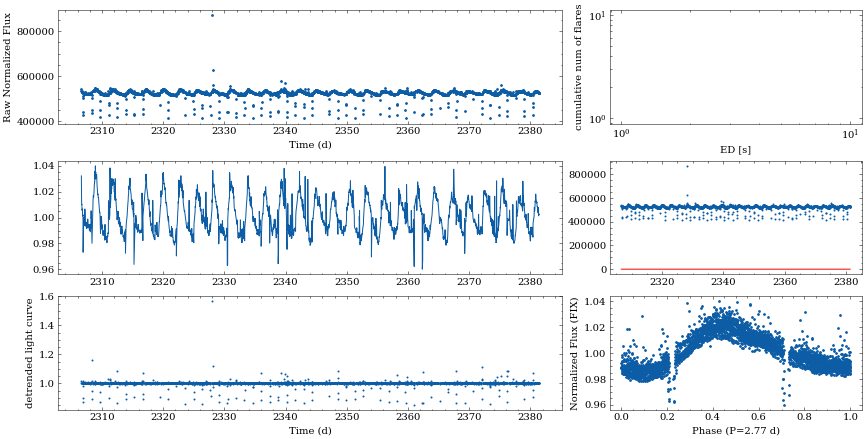

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,6345) gap.
Found 0 candidate(s) in the (6345,12584) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


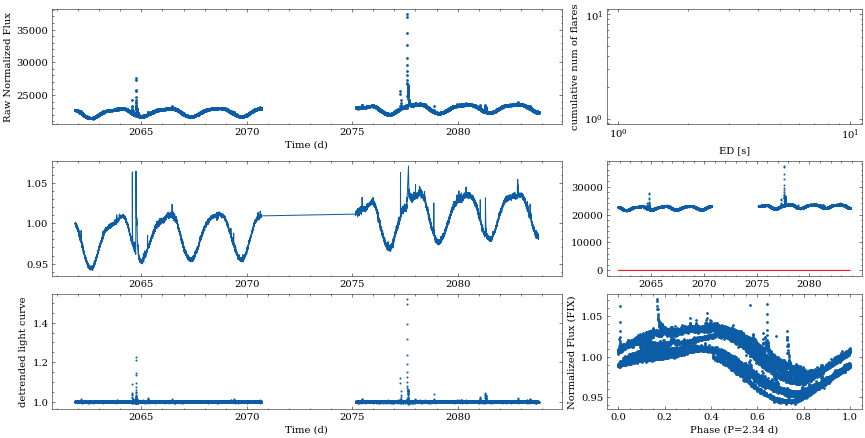

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,6252) gap.
Found 0 candidate(s) in the (6252,12319) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


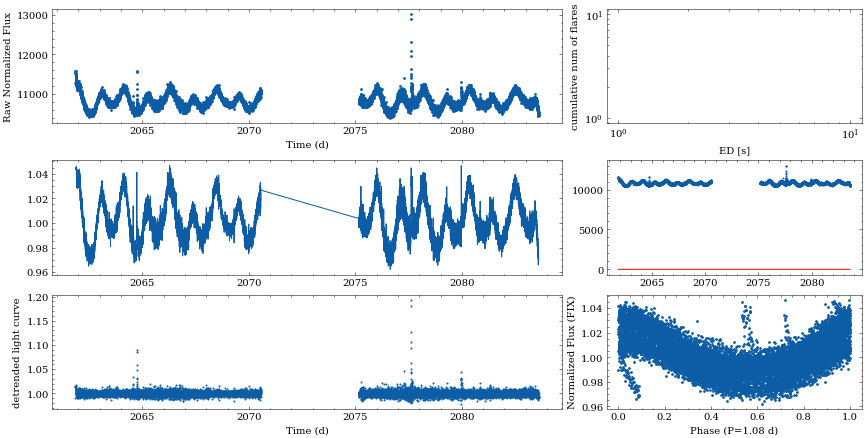

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8795) gap.
Found 0 candidate(s) in the (8795,16565) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


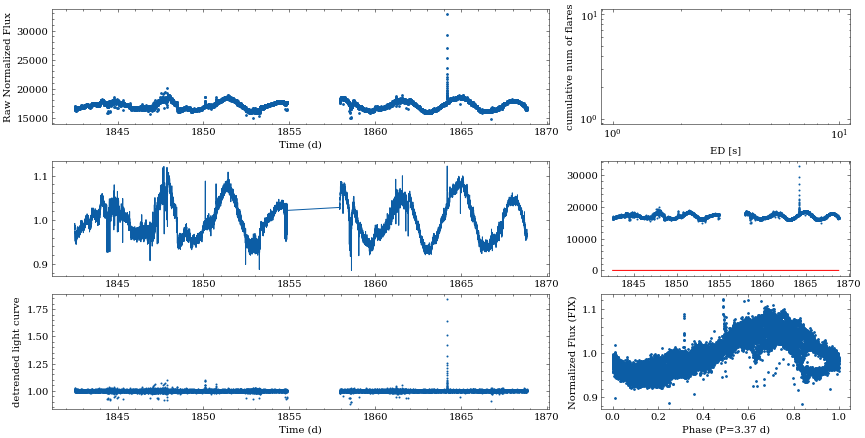

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,9409) gap.
Found 0 candidate(s) in the (9409,18277) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


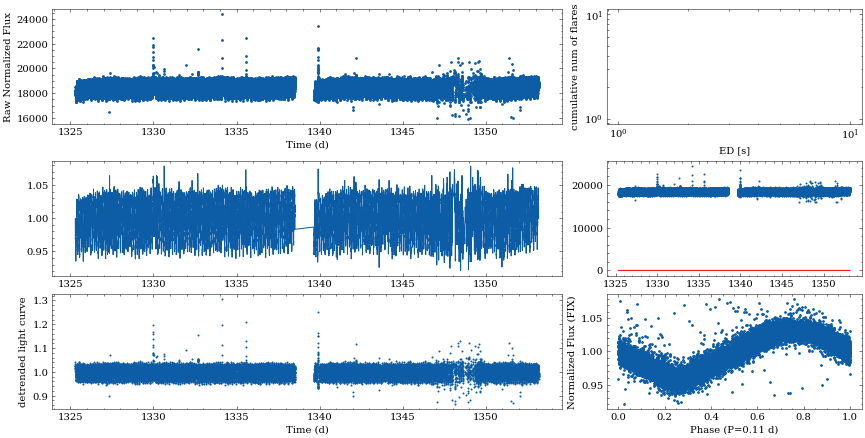

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8476) gap.
Found 0 candidate(s) in the (8476,17110) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


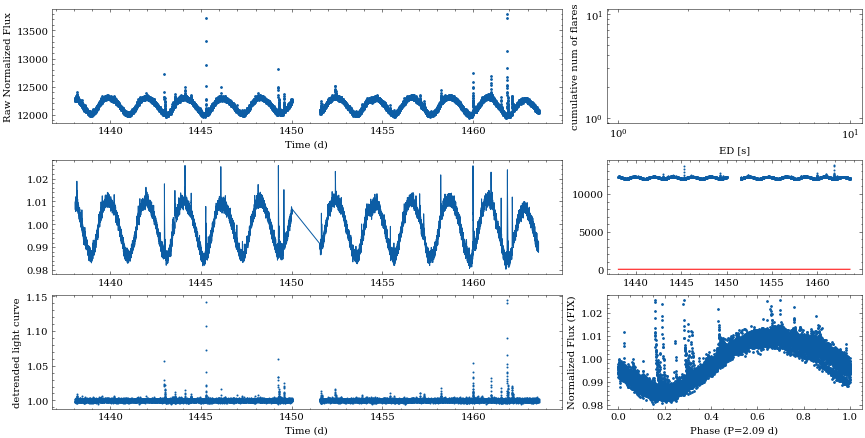

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,7974) gap.
Found 0 candidate(s) in the (7974,15620) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


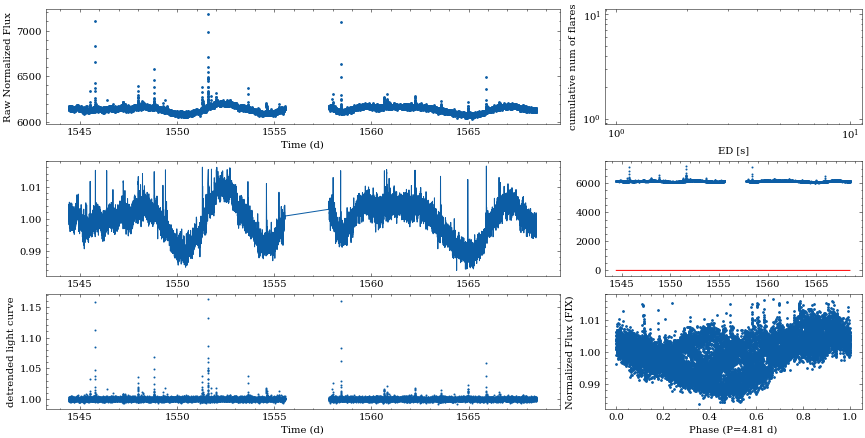

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8271) gap.
Found 0 candidate(s) in the (8271,16228) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


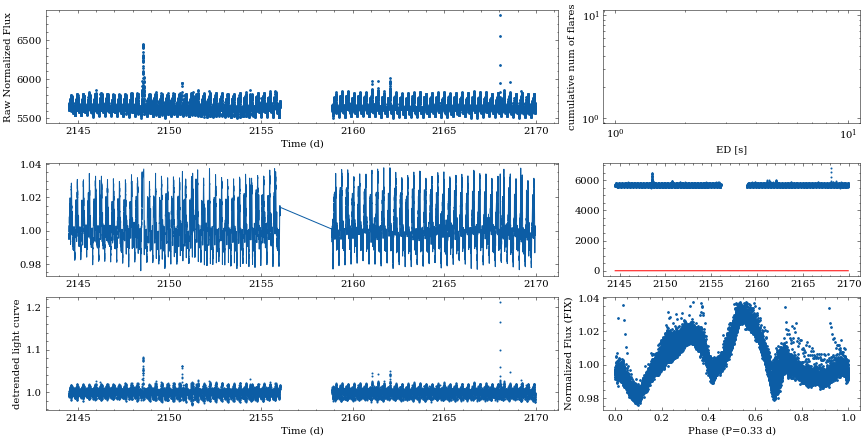

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,9712) gap.
Found 0 candidate(s) in the (9712,19439) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


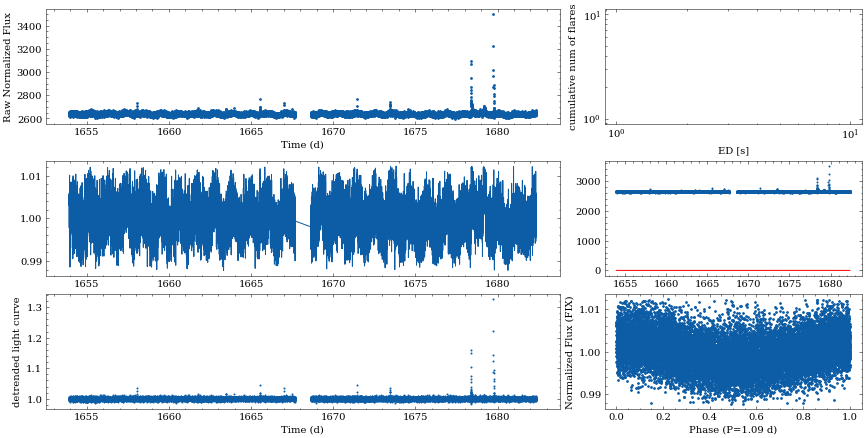

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8535) gap.
Found 0 candidate(s) in the (8535,17216) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\U

error


KeyboardInterrupt: 

In [12]:
tic_ids = pd.read_csv('C:/Users/60002/Documents/GitHub/sunnyhills/data/current/closest_50.csv')
for id in tic_ids['TIC_ID']:
   lc_dir = 'C:/Users/60002/Documents/GitHub/sunnyhills/data/current/tess_lightcurves'
   id =int(id)
   make_plot(str(id), lc_dir)